<a href="https://colab.research.google.com/github/arahrooh31/UCLA_BE223C/blob/Keane_temp/get_dbt_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%load_ext autoreload
#%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import gc  #debug memory leaks in matplotlib
import csv #read in description files
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 

import pydicom #to read dicom files
from pydicom import dcmread

#imports needed for dbtex function
print('---dbtex installs---')
!pip3 install -q pylibjpeg  #for dbtex
!pip3 install -q python-gdcm
!pip3 install -q pylibjpeg-libjpeg 
!pip3 install -q pylibjpeg-openjpeg
!pip3 install -q Pillow


import PIL
import pylibjpeg

#
# Load data from google drive
#

drive.mount('/content/gdrive')




     |████████████████████████████████| 1.9MB 5.5MB/s 
---dbtex installs---
     |████████████████████████████████| 3.6MB 6.6MB/s 
     |████████████████████████████████| 9.4MB 4.6MB/s 
     |████████████████████████████████| 4.2MB 5.2MB/s 
Mounted at /content/gdrive


In [2]:
### set up drives for including .py files
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'BE223C_SPRING_2021/PY_FILES'
GOOGLE_DRIVE_PATH = os.path.join('/content/gdrive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time
os.environ["TZ"] = "US/Eastern"
time.tzset()

#import dbtex_dbt_data


['dbtex_dbt_data.py', '__pycache__']


In [6]:
#code borrowed from
#https://gist.github.com/cmarasinou/7c990a4835e80874b4de5f2433612d65
###############testing out embedded function, as .py import failing

from typing import AnyStr, BinaryIO, Optional, Union

import numpy as np
import pydicom as dicom
from skimage.exposure import rescale_intensity


def dcmread_image(
    fp: Union[str, "os.PathLike[AnyStr]", BinaryIO],
    view: str,
    index: Optional[np.uint] = None,
) -> np.ndarray:
    """Read pixel array from DBT DICOM file"""
    ds = dicom.dcmread(fp)
    ds.decompress(handler_name='pillow') #pylibjpeg')
    pixel_array = ds.pixel_array
    view_laterality = view[0].upper()
    image_laterality = _get_image_laterality(pixel_array[index or 0])
    if index is not None:
        pixel_array = pixel_array[index]
    if not image_laterality == view_laterality:
        pixel_array = np.flip(pixel_array, axis=(-1, -2))
        print("Laterality fixed!")
    window_center = _get_window_center(ds)
    window_width = _get_window_width(ds)
    low = (2 * window_center - window_width) / 2
    high = (2 * window_center + window_width) / 2
    pixel_array = rescale_intensity(
        pixel_array, in_range=(low, high), out_range="dtype"
    )
    return pixel_array


def _get_dicom_laterality(ds: dicom.dataset.FileDataset) -> str:
    """Unreliable - DICOM laterality is incorrect for some cases"""
    return ds[0x5200, 0x9229][0][0x0020, 0x9071][0][0x0020, 0x9072].value


def _get_image_laterality(pixel_array: np.ndarray) -> str:
    left_edge = np.sum(pixel_array[:, 0])  # sum of left edge pixels
    right_edge = np.sum(pixel_array[:, -1])  # sum of right edge pixels
    return "R" if left_edge < right_edge else "L"


def _get_window_center(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1050].value)


def _get_window_width(ds: dicom.dataset.FileDataset) -> np.float32:
    return np.float32(ds[0x5200, 0x9229][0][0x0028, 0x9132][0][0x0028, 0x1051].value)

In [3]:
'''
GET DIR LISTING----------------------------------------------------------------
'''
def get_dirs(top_dir): 
    import os

    dir_list = os.scandir(top_dir)
    directories=[]
    patient_data = {}
    for ii in dir_list:
        print('top dir is ',ii)
        if (ii.is_dir()):
            #patient ID directory
            patient_id = ii.name
            patient_data[patient_id]={}
            directories.append(ii.name)
            #get file listings for each directory found
            full_name = os.path.join(top_dir,ii.name)
            print(ii,full_name)

            files = os.scandir(full_name)
            for patient_uid in files:
                print('------ ',patient_uid.name)

            if (patient_uid.is_dir()):
                #this will be the longer directory name
                #with study id
                #This will need to be tokenized to get 
                #the two fields out for info
                #--for now, keep the longer directory name
                patient_data[patient_id][patient_uid.name]={}

                exam_listings = os.scandir(os.path.join(full_name, 
                                                  patient_uid.name))
                for exam_number in exam_listings:
                    patient_data[patient_id][patient_uid.name][exam_number.name] =[]
                    #fill this in with exam dcm contents
                    dcm_list = os.listdir(os.path.join(full_name, 
                                                  patient_uid.name,
                                                  exam_number.name))
                    for dcm_file in dcm_list:
                        patient_data[patient_id][patient_uid.name][exam_number.name].append(dcm_file)

        else:
            print('*** found single file ',ii.name)

    
    return patient_data

In [14]:
def get_csv_data(filename):
    fields = []
    rows = []

    # reading csv file
    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)
        
        # extracting field names through first row
        fields = next(csvreader)

        # extracting each data row one by one
        for row in csvreader:
            rows.append(row)


        # lines present
        print("found rows: %d"%(csvreader.line_num))
    return fields, rows

In [ ]:
### Main level
top_dir = '/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT'
png_dir = '/content/gdrive/My Drive/BE223C_SPRING_2021/PNG_IMAGES'

upper_dir =top_dir

patient_data = get_dirs(upper_dir)


In [82]:
#READ CSV FILES
csv_dir = '/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/'
csv_list = os.listdir(csv_dir)

for csv_file in csv_list:
    filename = os.path.join(csv_dir,csv_file)
    if ('path' in csv_file):
        path_fields, path_rows = get_csv_data(filename)
    elif('labels' in csv_file):
        label_fields, label_rows = get_csv_data(filename)        
    elif('boxes' in csv_file):
        boxes_fields, boxes_rows = get_csv_data(filename)
    else:
        print('Non-archive file found ',filename)

print('box shape is ',np.shape(boxes_rows))

num_slices = np.double(np.array(boxes_rows)[:,[11]])
print('min slices, max slices = ',np.amin(num_slices), np.amax(num_slices))


Non-archive file found  /content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/manifest-1605042674814
found rows: 225
found rows: 2597
found rows: 2597
box shape is  (224, 12)
min slices, max slices =  24.0 114.0


In [20]:
file = '/content/gdrive/My Drive/DBT_DATA/TEST_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00118/01-01-2000-DBT-S05386-MAMMO screening digital bilateral-70928/7697.000000-17471/1-1.dcm'



img_data = dcmread_image(file,'0')

#dcmread_image(
#    fp: Union[str, "os.PathLike[AnyStr]", BinaryIO],
#    view: str,
#    index: Optional[np.uint] = None,
#)

/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


Laterality fixed!


size of return is  (53, 2457, 1890)


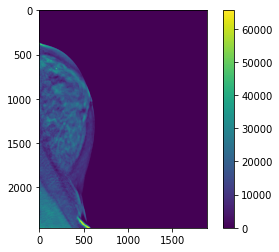

In [23]:
print('size of return is ',img_data.shape)
plt.figure()
plt.imshow(img_data[0,:,:])
plt.colorbar()

In [ ]:
#
# Show the final DCM files found
#
make_png = 1
f1 = plt.figure(dpi=1200) #reuse the figure to avoid memory leak
for patient_id in patient_data.keys():
    for patient_uid in patient_data[patient_id].keys():
        for exam_number in patient_data[patient_id][patient_uid].keys():
            counter = 0
            for dcm_file in patient_data[patient_id][patient_uid][exam_number]:
                dcm_full_file = os.path.join(upper_dir,patient_id, patient_uid, exam_number,dcm_file)
                print(dcm_full_file)
                img_data = dcmread_image(dcm_full_file,'0')
                #ds = dcmread(dcm_full_file)
                #print(ds.PatientName)
                #ds.file_meta.TransferSyntaxUID
                #open a new figure to hold the slice image

                if (make_png == 1):
                    print('--- OPEN FIG ---')
                    if (img_data.size <1):
                        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ',img_data.size)
                    #f1=plt.figure(dpi=800)
                    plt.imshow(img_data[0,:,:], cmap=plt.cm.bone)
                    #plt.imshow(ds.pixel_array[0,:,:], cmap=plt.cm.bone)
                    plt.colorbar()
                    title_text = str(patient_id) + '_' + str(exam_number)
                    plt.title(title_text)
                    fname = str(exam_number) + '_' + str(counter) + str('.png')
                    save_filename = os.path.join(png_dir,fname)
                    print('-- SAVE&CLOSE FIG')
                    plt.savefig(save_filename)
                    plt.cla()
                    plt.clf()
                    #del f1
                    #plt.close("all")
                    #ds = None #clear pydicom, memory leak if not
                del img_data    #  img_data = None
                gc.collect() #collect garbage
            counter = counter + 1



#

/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00013/01-01-2000-DBT-S00163-MAMMO DIAGNOSTIC DIGITAL BILATERAL-56865/20566.000000-32081/1-1.dcm


/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


Laterality fixed!
--- OPEN FIG ---
-- SAVE&CLOSE FIG
/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00064/01-01-2000-DBT-S02651-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-15803/20256.000000-46869/1-1.dcm
Laterality fixed!
--- OPEN FIG ---
-- SAVE&CLOSE FIG
/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00064/01-01-2000-DBT-S02651-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-15803/20257.000000-89476/1-1.dcm
Laterality fixed!
--- OPEN FIG ---
-- SAVE&CLOSE FIG
/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00064/01-01-2000-DBT-S02651-MAMMO SCREEN BREAST TOMOSYNTHESIS BILATERAL-15803/20258.000000-36685/1-1.dcm
Laterality fixed!
--- OPEN FIG ---
-- SAVE&CLOSE FIG
/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00064/01-01-2000-DBT-S02651-MAMMO SCREEN BREAST TOMOSYNTH

/usr/local/lib/python3.7/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


Laterality fixed!
CPU times: user 52.7 s, sys: 1.26 s, total: 54 s
Wall time: 54.2 s


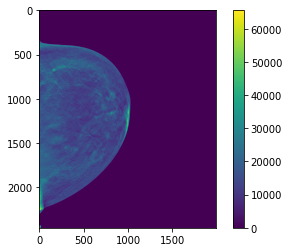

In [9]:
#find set that is causing memory issue
debug_file = '/content/gdrive/My Drive/DBT_DATA/TRAINING_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00122/01-01-2000-DBT-S02054-MAMMO diagnostic digital bilateral-19089/3941.000000-93960/1-1.dcm'

%time img_data = dcmread_image(debug_file,'0')
plt.figure()
plt.imshow(img_data[0,:,:])
plt.colorbar()


In [13]:
print(img_data.size)
img_data.shape
81*2457*1996

397237932


397237932

In [ ]:
 '''
 ###
 ### Build links to dcm files
 ###
 print('upper dir = ',upper_dir)
 counter = 0
 patient_folder = {} #store dcm files
 for root, directories, filenames in os.walk(upper_dir): 
    #print('base is ', os.path.basename(directories))
    for directory in directories:
        #create dictionary entry for this directory. The files will be stored
        #within this
        patient_path = os.path.join(root, directory) #link to direct pt folder
        print('root, dir = ',root,patient_path)
        #for every directory found in the patient directory, get a listing of
        #files in each 
        patient_files = os.listdir(patient_path)
        for file in patient_files:
            if ('.dcm' in file):
                if (directory not in patient_folder.keys()):
                    patient_folder[directory] = []
                patient_folder[directory].append(patient_files)
    #for filename in filenames:  
    #    print('f= ',os.path.join(root,filename))
    #    counter = counter + 1
    #    if (counter > 10):
    #        break
    #if (counter > 10):
    #    break

In [ ]:
for ii in patient_folder.keys():
    print(ii)

In [ ]:
### Open dcm file
###
'''
from pydicom import dcmread
file = '/content/gdrive/My Drive/DBT_DATA/TEST_DATA/manifest-1605042674814/Breast-Cancer-Screening-DBT/DBT-P00118/01-01-2000-DBT-S05386-MAMMO screening digital bilateral-70928/7697.000000-17471/1-1.dcm'


ds = dcmread(file)
print(ds.PatientName)
ds.file_meta.TransferSyntaxUID
plt.imshow(ds.pixel_array[0,:,:], cmap=plt.cm.bone) 


In [ ]:
'''
np.shape(ds.pixel_array)
ds_slice = ds.pixel_array[0,:,:]
plt.imshow(ds_slice, cmap=plt.cm.jet)
plt.colorbar()

In [ ]:
while True:pass